<a href="https://colab.research.google.com/github/faisalrasbihan/gru-momentum-trading/blob/main/automated_gru8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Preamble

In [7]:
import json
import requests
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import missingno as msno

# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, Conv1D, GRU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K

# Data Visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# import shap
import seaborn as sns
sns.set()

from io import BytesIO
import requests

# Import custom utility funciton 
import _data_processor as dp
import _visualize as viz
import _predict_model as pm
import _trade_simulation as tm

# 1. Iterate through symbols list

In [3]:
symbol_region = [('EIDO','US'),('SPY','US'),('IDX30.JK','ID'),('^JKLQ45','ID'),('^JKSE','ID')]
latest = pd.DataFrame()

for symbol,region in symbol_region:
    
    # Query yahoo finance with symbol and region specified
    querystring = {f"interval":"1d","symbol":symbol,"range":"5d","region":region}
#     print(querystring)
    url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-chart"
    headers = {
        'x-rapidapi-key': "2ae167d1a9msh2d45d09b2cdd5cap100809jsna472cae90b94",
        'x-rapidapi-host': "apidojo-yahoo-finance-v1.p.rapidapi.com"
    }
    response = requests.request("GET", url, headers=headers, params=querystring)
    
    # Create temp df from response to store quuery result
    result = json.loads(response.text)['chart']['result'][0]
    volume = result['indicators']['quote'][0]['volume']
    close = result['indicators']['quote'][0]['close']
    date = result['timestamp']
    data = {
        'date': date,
        symbol: close,
        f"{symbol}_VOL": volume,
    }
    temp = pd.DataFrame.from_dict(data)
    temp['date'] = pd.to_datetime(temp['date'],unit='s').dt.date
    temp.set_index(['date'], inplace=True)
#     print(temp)
    
    # Join temp df to main df by date, or create df with temp df if empty
    if latest.empty:
        latest = temp
#         print(latest)
    else:
        latest = latest.merge(temp, how='outer', left_index=True, right_index=True).copy()
        
latest.rename(columns={"IDX30.JK": "IDX30", 
                       "IDX30.JK_VOL": "IDX30_VOL", 
                       "^JKLQ45": "LQ45", 
                       "^JKLQ45_VOL": "LQ45_VOL", 
                       "^JKSE": "IHSG", 
                       "^JKSE_VOL": "IHSG_VOL"},
             inplace=True)

In [4]:
latest = latest[['EIDO','SPY','IDX30','LQ45','IHSG']]
latest['Volume'] = 1.47 * 10**9
# latest.to_csv('dataset/gru8_input.csv', mode='a', header=False)
latest

,EIDO,SPY,IDX30,LQ45,IHSG,Volume
date,,,,,,
2021-06-08,21.980000,422.279999,NaN,NaN,NaN,1.470000e+09
2021-06-09,22.160000,421.649994,NaN,898.909973,6047.475098,1.470000e+09
2021-06-10,22.389999,423.609985,NaN,905.419983,6107.538086,1.470000e+09
2021-06-11,22.250000,424.309998,NaN,901.640015,6095.497070,1.470000e+09
2021-06-14,21.950001,425.260010,NaN,895.890015,6080.383789,1.470000e+09
2021-06-15,NaN,NaN,477.274994,892.921021,6073.669922,1.470000e+09


# 2. Preprocess data

In [54]:
# Set constants
INPUT_VAR = ['momentum','IDX30_IHSG_grad','EIDO_SPY_grad','Volume_grad']
TARGET_VAR = 'target'

EIDO_SPY_SLOW_MA = 6
EIDO_SPY_FAST_MA = 6
IDX30_IHSG_SLOW_MA = 7
IDX30_IHSG_FAST_MA = 5
Volume_SLOW_MA = 10
Volume_FAST_MA = 6

MA_PERIOD = 5
FUTURE_DAYS = 3

In [56]:
googleSheetId = '13RkfCBGI-5df_dfvre0P-RlvJZc2NUpW5vx0On6bUjY'
workSheetName = 'Sheet1'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId,
    workSheetName
)
df = pd.read_csv(URL, sep=',',parse_dates=['Date'])

df

,Date,EIDO,SPY,IDX30,LQ45,IHSG,Volume,tot_buy,dom_total,for_flow
0,2012-04-24,30.880000,137.310000,358.940000,709.970000,4170.350000,6.870800e+08,4453953.125,-359126.625,6041530.0
1,2020-10-22,18.700000,344.610000,428.150000,788.560000,5091.820000,1.780000e+09,9353848.500,-262450.500,11146785.5
2,2020-10-23,18.900000,345.780000,428.300000,789.820000,5112.190000,1.570000e+09,8353186.000,-45693.000,12570627.5
3,2020-10-26,18.840000,339.390000,430.880000,794.210000,5144.050000,1.380000e+09,7126885.125,127978.125,10899793.0
4,2020-10-27,18.790000,338.220000,428.710000,790.500000,5128.230000,1.560000e+09,8549284.000,108244.000,12767308.0
...,...,...,...,...,...,...,...,...,...,...
129,2021-04-26,21.629999,417.609985,474.980000,892.180000,5964.820000,1.060000e+09,3524720.500,-226572.750,6203283.5
130,2021-04-27,21.530001,417.519989,474.410000,891.350000,5959.620000,1.200000e+09,2902870.250,-38980.250,6807731.0
131,2021-04-28,21.740000,417.399994,474.095001,890.901978,5974.479004,1.090000e+09,9644175.750,-476607.500,13813094.5
132,2021-04-29,21.870000,420.060000,478.080000,897.810000,6012.960000,1.280000e+09,9782288.500,-20140.000,14869813.0


In [58]:
def hampel(vals_orig, k=7, t0=3):
    #Make copy so original not edited
    vals = vals_orig.copy()
    
    #Hampel Filter
    L = 1.4826
    rolling_median = vals.rolling(window=k, center=True).median()
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    rolling_MAD = vals.rolling(window=k, center=True).apply(MAD)
    threshold = t0 * L * rolling_MAD
    difference = np.abs(vals - rolling_median)
    
    outlier_idx = difference > threshold
    vals[outlier_idx] = rolling_median[outlier_idx] 
    return outlier_idx, vals

In [59]:
outlier_idx, dom_filtered = hampel(df.dom_total,k=20,t0=9)
dom_outlier = df.dom_total.copy()
dom_outlier[~outlier_idx] = np.nan

df['dom_filtered'] = dom_filtered

outlier_idx, for_filtered = hampel(df.for_flow,k=20,t0=9)
for_outlier = df.for_flow.copy()
for_outlier[~outlier_idx] = np.nan

df['for_flow_filtered'] = for_filtered

outlier_idx, total_buy_filtered = hampel(df.tot_buy,k=20,t0=9)
tot_outlier = df.tot_buy.copy()
tot_outlier[~outlier_idx] = np.nan
df['total_buy_filtered'] = total_buy_filtered

In [60]:
df = df.resample('D').mean()
df['LQ45'] = df['LQ45'].ffill()
df['Volume'] = df['Volume'].ffill()
df['IDX30'] = df['IDX30'].ffill()
df['IHSG'] = df['IHSG'].ffill()
df['EIDO'] = df['EIDO'].ffill()
df['SPY'] = df['SPY'].ffill()
df['dom_filtered'] = df['dom_filtered'].ffill()
df['for_flow_filtered'] = df['for_flow_filtered'].ffill()
df['total_buy_filtered'] = df['total_buy_filtered'].ffill()

# Remove saturday and sunday data
df['day_of_week'] = df.index.dayofweek + 1
df = df[df['day_of_week'] < 6].copy()
df.drop(columns=['day_of_week'],inplace=True)

df['target'] = df['LQ45'].pct_change(periods=FUTURE_DAYS).shift(-(FUTURE_DAYS-1)) * 100

# Add linear series
df['linear_series'] = (df.reset_index().index + 1000) / 1000

# Calculate momentum
df['momentum'] = dp.momentum_transformation(df, 'LQ45', ma_span=4, normalized=False)

# Calculate foreign flow, dom_val, total_buy
df['dom_filtered'] = df['dom_filtered'] / (10**6)
df['for_flow_filtered'] = df['for_flow_filtered'] / (10**6)
df['total_buy_filtered'] = df['total_buy_filtered']/(10**6)

df['dom_val_ma'] = df['dom_filtered'].rolling(7).mean()
df['for_flow_ma'] = df['for_flow_filtered'].rolling(7).mean()
df['dom_val_grad'] = df['dom_filtered'].rolling(3).mean() - df['dom_filtered'].rolling(11).mean().shift(3)
df['for_flow_grad'] = df['for_flow_filtered'].rolling(3).mean() - df['for_flow_filtered'].rolling(11).mean().shift(3)
df['total_val_grad'] = df['total_buy_filtered'].rolling(3).mean() - df['total_buy_filtered'].rolling(11).mean().shift(3)

# Rescale volume
df['Volume'] = df['Volume']/1000000000
df.loc[df.Volume > 13, 'Volume'] = np.nan

# Calculate gradient
df['EIDO'] = 100*df['EIDO']/df['EIDO'][0]
df['SPY'] = 100*df['SPY']/df['SPY'][0]
df['IDX30'] = 100*df['IDX30']/df['IDX30'][0]
df['IHSG'] = 100*df['IHSG']/df['IHSG'][0]

# Remove oldest data
df = df[1:].copy()

df['EIDO_SPY_diff'] = df['EIDO'] - df['SPY']
df['EIDO_SPY_grad'] = df['EIDO_SPY_diff'].rolling(EIDO_SPY_FAST_MA).mean() - df['EIDO_SPY_diff'].rolling(EIDO_SPY_SLOW_MA).mean().shift(EIDO_SPY_FAST_MA)
df['IDX30_IHSG_diff'] = df['IDX30'] - df['IHSG']
df['IDX30_IHSG_grad'] = df['IDX30_IHSG_diff'].rolling(IDX30_IHSG_FAST_MA).mean() - df['IDX30_IHSG_diff'].rolling(IDX30_IHSG_SLOW_MA).mean().shift(IDX30_IHSG_FAST_MA)
df['Volume_ma'] = df['Volume'].rolling(14).mean()
df['Volume_grad'] = df['Volume'].rolling(Volume_FAST_MA).mean() - df['Volume'].rolling(Volume_SLOW_MA).mean().shift(Volume_FAST_MA)

TypeError: ignored

In [ ]:
# Sanity Check
df = df[df.index > '2020-11-09']
# df_sv = df[INPUT_VAR + ['dom_val_ma','for_flow_ma','total_val_grad'] + [TARGET_VAR]].copy()
df[INPUT_VAR + ['dom_val_ma','for_flow_ma','total_val_grad'] + [TARGET_VAR]]

# 3. Run model seitan

# Run Model `high_acc`

In [61]:
gru8_high_acc_1 = tf.keras.models.load_model('gru8_high_acc_1_64.hdf5', compile=False )
gru8_high_acc_2 = tf.keras.models.load_model('gru8_high_acc_2_65.hdf5', compile=False )
gru8_high_acc_3 = tf.keras.models.load_model('gru8_high_acc_4_64.hdf5', compile=False )
gru8_high_acc_4 = tf.keras.models.load_model('gru8_high_acc_5_65.hdf5', compile=False )
gru8_high_acc_6 = tf.keras.models.load_model('gru8_high_acc_6_66.hdf5', compile=False )
gru9_high_acc_ffill_1 = tf.keras.models.load_model('gru9_high_acc_ffill_1.hdf5', compile=False )
gru9_high_acc_ffill_2 = tf.keras.models.load_model('gru9_high_acc_ffill_2.hdf5', compile=False )
gru9_high_acc_ffill_3 = tf.keras.models.load_model('gru9_high_acc_ffill_3.hdf5', compile=False )

input_timesteps = 20
output_timesteps = 1
day_count = 10

OSError: ignored

In [62]:
MEAN = 0.06968521192214656
STD = 2.3073312870270306
def target_inverse_transform(x, mean=MEAN, std=STD):
    return (x*STD) + MEAN

In [63]:
def generate_prediction(m, X, y, dates):
    pred = m.predict(X)[:,0]
    true = y[:,0]
    
    # Determine true and pred
    s = pd.DataFrame()
    s['true_bin'] = np.where(true < 0, -1, 1)
    s['pred_bin'] = np.where(pred < 0, -1, 1)
    s['true']  = true
    s['pred'] = pred
    
    # Calculate error
    s['mse'] = np.abs(s['true'] - s['pred']).rolling(7).sum()
    s['squared_hinge'] = 1 - s['true'] * s['pred']
    s.loc[s['squared_hinge'] < 0,'squared_hinge'] = 0
    s['squared_hinge'] = s['squared_hinge']**2
    s['rolling_error'] = s['squared_hinge'].rolling(7).mean()
    
    # Add Date
    s['date'] = dates
    s['date_str'] = s['date'].dt.strftime('%Y-%m-%d')
    s['date_to_val'] = s['date'].map(pd.Series(data=np.arange(len(s)), 
                                                                     index=s['date'].values).to_dict())
#     s['true_in_pct'] = target_inverse_transform(s['true'])
#     s['pred_in_pct'] = target_inverse_transform(s['pred'])
#     s['correct_sign'] = np.sign(target_inverse_transform(s['pred']) * target_inverse_transform(s['true']))
#     s['correct_sign'] = np.where(s['correct_sign'] < 1, 0, 1)
#     s['rolling_acc'] = s['correct_sign'].rolling(20).sum()
    
    return pred,true,s


In [64]:
def determine_buy_sell_acc(s, buy_thresh, sell_thresh):
    s['pred_position'] = np.where(s.pred < sell_thresh, 'SELL', np.where(s.pred > buy_thresh, 'BUY', 'HOLD'))
    s['actual_position'] = np.where(s.true < sell_thresh, 'SELL', np.where(s.true > buy_thresh, 'BUY', 'HOLD'))
    s['correct_position'] = (s['pred_position'] == s['actual_position']).astype(int)
    s['position_acc'] = s['correct_position'].rolling(20).sum() / 20
    return s

In [65]:
def calc_rolling_acc(s):
    s['true_in_pct'] = target_inverse_transform(s['true'])
    s['pred_in_pct'] = target_inverse_transform(s['avg_pred'])
    s['correct_sign'] = np.sign(target_inverse_transform(s['avg_pred']) * target_inverse_transform(s['true']))
    s['correct_sign'] = np.where(s['correct_sign'] < 1, 0, 1)
    s['correct_count'] = s['correct_sign'].rolling(20).sum()
    s['rolling_acc'] = s['correct_count'] / 20
    return s

In [66]:
def plot_returns(df, closing_price_name='Close', value_range=6, title='Simulated Returns'):
    fig, ax = plt.subplots(4, 1, sharex=True, figsize=[16, 12])
    fig.suptitle(title, fontsize=20)

    # Add patch as legend
    red_patch = mpl.patches.Patch(color='#bb3f3f', label='Sell')
    green_patch = mpl.patches.Patch(color='#008000', label='Buy')
    
    # Closing price chart
    close = 100*df[closing_price_name]/df[closing_price_name][0]
    sns.lineplot(data=close, ax=ax[0])
    ax[0].set_ylabel(closing_price_name)
    buys = df.loc[df.position == 'Buy'] # mark buy transactions
    sells = df.loc[df.position == 'Sell'] # mark sell transactions
    
    # Add dashed line on last closing price
    last_closing_price = close[-1]
    ax[0].axhline(last_closing_price, ls='--',linewidth=1, color='m')
    ax[0].plot(buys.index, close.loc[buys.index], '^', markersize=8, color='g', label='buy')
    ax[0].plot(sells.index, close.loc[sells.index], 'v', markersize=8, color='r', label='sell')
    ax[0].annotate((last_closing_price).round(2),xy=(1,last_closing_price),xycoords=('axes fraction','data'),ha='left',va='center',color='black')
    ax[0].grid(True)
    ax[0].legend(handles=[red_patch, green_patch])

    # Price change chart
    value_cols = df.columns[:value_range]
    melted_df = df[value_cols].reset_index()
    melted_df = pd.melt(melted_df, id_vars=['date'], value_vars=value_cols)
    ax2 = ax[1].twinx().grid(False)
    sns.lineplot(data=melted_df, x='date', y='value', ax=ax[1])
    sns.lineplot(data=df, x='date', y='target', color='orange', ax=ax2)
    b_patch = mpl.patches.Patch(color='b', label='prediction')
    o_patch = mpl.patches.Patch(color='orange', label='target')
    ax[1].set_ylabel('prediction'.format(3))
    ax[1].grid(True)
    ax[1].legend(handles=[b_patch, o_patch])

    # Portfolio value
    port_value = df['value'] / df['value'][0]
    sns.lineplot(data=port_value, dashes=[(2,2)], ax=ax[2])
    ax[2].set_ylabel('Simulated Portfolio Value')
    last_value = port_value[-1]
    ax[2].axhline(last_value, ls='--',linewidth=1, color='m')
    ax[2].annotate((last_value).round(2),xy=(1,last_value),xycoords=('axes fraction','data'),ha='left',va='center',color='black')
    ax[2].grid(True)
    
    # Rolling Accuracy
    sns.lineplot(data=df['position_acc'], dashes=[(2,2)], color='g', marker="o", ax=ax[3])
    ax[3].set_ylabel('20-Day Buy/Sell/Hold Accuracy')
    ax[3].grid(True)
    
    return fig

In [67]:
X_current, y_current = dp.generate_batch(df, 
                                         input_timesteps,
                                         output_timesteps,
                                         INPUT_VAR,
                                         TARGET_VAR)


_,_,current_result = generate_prediction(gru8_high_acc_1,
                                               X_current,
                                               y_current,
                                               df.index[(input_timesteps+output_timesteps-1):])

NameError: ignored

In [ ]:
ha_df

In [ ]:
from datetime import date

models = [gru8_high_acc_1,gru8_high_acc_2,gru8_high_acc_3,gru8_high_acc_4,gru8_high_acc_6,gru9_high_acc_ffill_1,gru9_high_acc_ffill_2]
models_name = ['gru8_high_acc_1','gru8_high_acc_2','gru8_high_acc_3','gru8_high_acc_4','gru8_high_acc_6','gru9_high_acc_ffill_1','gru9_high_acc_ffill_2']
pred_ensemble = []
ha_date_prediction = pd.DataFrame()

# Genrate prediction from all model
for index,model in enumerate(models):
    pred,true,current_result = generate_prediction(model,
                                               X_current,
                                               y_current,
                                               df.index[(input_timesteps+output_timesteps-1):])
    val = target_inverse_transform(current_result['pred'].iloc[-day_count:].values).round(2) # get last X days
    pred_ensemble.append(val)
    ha_date_prediction['date'] = current_result['date']
    ha_date_prediction[f'nd_pred_{index}'] = current_result['pred']

# Convert to ndarray
pred_ensemble_npa = np.array(pred_ensemble)
today = date.today()

# Display and save result
ha_df = pd.DataFrame.from_dict({'model': models_name})

def highlight_sign(s): 
    res = ['color: red;' if x < -0.28 else 'color: green;' if x > 0.17 else 'color:black' for x in s] 
    return res

ha_df[today.strftime("%b %d, %Y")] = pred_ensemble_npa[:,-1]
for d in range(1, day_count):
    ha_df[df.index[-d].date().strftime("%b %d, %Y")] = pred_ensemble_npa[:,-1-d]
    
# Add avg, median
ha_df.loc[ha_df.index.max() + 1] = ['AVERAGE'] + np.flip(np.average(pred_ensemble_npa, axis=0),0).tolist()
ha_df.loc[ha_df.index.max() + 1] = ['MEDIAN'] + np.flip(np.median(pred_ensemble_npa, axis=0),0).tolist()

# Addd actual 3-day lQ45
# blender.loc[blender.index.max() + 1] = ['LQ45 3-DAY CHG'] + lq45_actual
lq45_actual = [np.nan] + np.flip(target_inverse_transform(current_result['true'].iloc[-day_count:].values).round(2)).tolist()[:-1]
ha_df.loc[ha_df.index.max() + 1] = ['LQ45 3-DAY CHG'] + lq45_actual

# Create dataframe to display portfolio value over time
ha_date_prediction.date = ha_date_prediction.date.shift(-1)
ha_date_prediction.date.iat[-1] = datetime.today().strftime('%Y-%m-%d')
ha_date_prediction.set_index(['date'],inplace=True)
ha_date_prediction['avg_pred'] = ha_date_prediction.mean(axis=1)
ha_date_prediction['median_pred'] = ha_date_prediction.median(axis=1)
ha_date_prediction['pred'] = ha_date_prediction['avg_pred']
ha_date_prediction['true'] = current_result['true'].values

# Styling and Display table
ha_df.set_index(['model'],inplace=True)
ha_df_styled = ha_df.style.format('{0:,.2f}%', na_rep="-")
ha_df_styled = ha_df_styled.set_caption("LQ45 Future 3-Day Forecast - high_acc model").apply(highlight_sign)
ha_df_styled = ha_df_styled.apply(lambda x: ['background: lightblue' if x.name in ['AVERAGE','MEDIAN','LQ45 3-DAY CHG'] else '' for i in x], axis=1)
ha_df_styled = ha_df_styled.apply(lambda x: ['background: gold' if x.name in ['LQ45 3-DAY CHG'] else '' for i in x], axis=1)
ha_df_styled

In [ ]:
res = ha_date_prediction.pipe(determine_buy_sell_acc, 0.15, -0.20)
res = ha_date_prediction.pipe(calc_rolling_acc)
res = res.merge(df[['LQ45','target']], how='left', left_index=True, right_index=True).copy()
res = res[:-1] # Remove last element because NaN

ha_returns = tm.simulate_position(res, 0.15, -0.20, closing_price_name='LQ45',buy_fee=0.0025,sell_fee=0.003)#dp.generate_returns(res)
ha_fig = plot_returns(ha_returns, closing_price_name='LQ45', title='')
ha_fig.savefig('ha_fig.png', bbox_inches='tight')

In [68]:
def plot_gauge(value):
    color = 'red'
    recommendation = 'Sell'
    val = value * 10
    if val > -2:
        color = 'yellow'
        recommendation = 'Hold'
    if val > 1.5:
        color = 'green'
        recommendation = 'Buy'

    fig = go.Figure(go.Indicator(
        mode = "gauge+number",
        value = (val + 10)/2,
        domain = {'x': [0, 1], 'y': [0, 1]},
        title = {"text": "Recommendation : <span style='font-size:1.2em;font-weight: bold;color:"+color+"'>" +recommendation+ "</span>"},
        gauge = {'axis': {'range': [0, 10]},
                 'bar': {'color': color},
                 'steps' : [
                     {'range': [0, 4], 'color': "white"},
                     {'range': [4, 6], 'color': "lightgray"},
                     {'range': [6, 10], 'color': "gray"}],'threshold': {
            'line': {'color': "red", 'width': 4},
            'thickness': 0.9,
            'value': (val + 10)/2}}))

    fig.show()
    fig.write_image(file='gekko_gauge.png', format='.png')
    
plot_gauge(res.avg_pred[-1])

NameError: ignored

# Run model `gekko`

In [ ]:
# Order is different from GRU7_refactored code
INPUT_VAR2 = ['momentum','IDX30_IHSG_grad','EIDO_SPY_grad','total_val_grad','for_flow_ma','dom_val_ma']
diamond_hand_1 = tf.keras.models.load_model('gekko/gekko1.hdf5', compile=False )
diamond_hand_2 = tf.keras.models.load_model('gekko/gekko2.hdf5', compile=False )
diamond_hand_3 = tf.keras.models.load_model('gekko/gekko3.hdf5', compile=False )
diamond_hand_4 = tf.keras.models.load_model('gekko/gekko4.hdf5', compile=False )
diamond_hand_5 = tf.keras.models.load_model('gekko/gekko5.hdf5', compile=False )

In [ ]:
# df['momentum'] = dp.momentum_transformation(df, 'LQ45', ma_span=4, normalized=False)
df[INPUT_VAR2].tail(50)

,momentum,IDX30_IHSG_grad,EIDO_SPY_grad,total_val_grad,for_flow_ma,dom_val_ma
Date,,,,,,
2021-02-22,3.630000,-1.549116,-1.270722,-0.715673,20.394832,-0.106443
2021-02-23,8.465000,-1.029987,-0.129386,0.023460,20.707986,-0.037306
2021-02-24,-2.535000,-0.602988,0.297941,2.030523,21.167598,0.104980
2021-02-25,-0.887500,-0.341243,1.471132,1.546248,21.119597,0.167836
2021-02-26,-7.055000,-0.371491,2.711847,4.654130,21.743407,0.168898
2021-03-01,13.787500,-0.006637,2.916011,3.835739,21.814481,0.173242
2021-03-02,9.492500,-0.063436,2.645367,3.275145,22.194230,0.175230
2021-03-03,6.132500,-0.047189,2.586752,-0.710991,21.479434,0.193781
2021-03-04,-14.547500,-0.029475,3.768714,-0.974319,21.721732,0.124174


In [ ]:
X_current, y_current = dp.generate_batch(df, 
                                         input_timesteps,
                                         output_timesteps,
                                         INPUT_VAR2,
                                         TARGET_VAR)

models = [diamond_hand_1,diamond_hand_2,diamond_hand_3,diamond_hand_4,diamond_hand_5]
models_name = ['gekko1','gekko2','gekko3','gekko4','gekko5']
sv_pred_ensemble = []
sv_date_prediction = pd.DataFrame()

# Genrate prediction from all model
for index, model in enumerate(models):
    pred,true,current_result = generate_prediction(model,
                                               X_current,
                                               y_current,
                                               df.index[(input_timesteps+output_timesteps-1):])
    val = target_inverse_transform(current_result['pred'].iloc[-day_count:].values).round(2)
    sv_pred_ensemble.append(val) 
    sv_date_prediction['date'] = current_result['date']
    sv_date_prediction[f'sv_pred_{index}'] = current_result['pred']
    
# Convert to svarray
pred_ensemble_npa = np.array(sv_pred_ensemble)
today = date.today()

# Display asv save result
sv_df = pd.DataFrame.from_dict({'model': models_name})

def highlight_sign(s): 
    res = ['color: red;' if x < -0.28 else 'color: green;' if x > 0.17 else 'color:black' for x in s] 
    return res

sv_df[today.strftime("%b %d, %Y")] = pred_ensemble_npa[:,-1]
for d in range(1, day_count):
    sv_df[df.index[-d].date().strftime("%b %d, %Y")] = pred_ensemble_npa[:,-1-d]
    
# Add avg, median
sv_df.loc[sv_df.index.max() + 1] = ['AVERAGE'] + np.flip(np.average(pred_ensemble_npa, axis=0),0).tolist()
sv_df.loc[sv_df.index.max() + 1] = ['MEDIAN'] + np.flip(np.median(pred_ensemble_npa, axis=0),0).tolist()

# Addd actual 3-day lQ45
lq45_actual = [np.nan] + np.flip(target_inverse_transform(current_result['true'].iloc[-day_count:].values).round(2)).tolist()[:-1]
sv_df.loc[sv_df.index.max() + 1] = ['LQ45 3-DAY CHG'] + lq45_actual

# Create dataframe to display portfolio value over time
sv_date_prediction.date = sv_date_prediction.date.shift(-1)
sv_date_prediction.date.iat[-1] = datetime.today().strftime('%Y-%m-%d')
sv_date_prediction.set_index(['date'],inplace=True)
sv_date_prediction['avg_pred'] = sv_date_prediction.mean(axis=1)
sv_date_prediction['median_pred'] = sv_date_prediction.median(axis=1)
sv_date_prediction['pred'] = sv_date_prediction['avg_pred']
sv_date_prediction['true'] = current_result['true'].values

# Styling asv Display table
sv_df.set_index(['model'],inplace=True)
sv_df_styled = sv_df.style.format('{0:,.2f}%', na_rep="-")
sv_df_styled = sv_df_styled.set_caption("LQ45 Future 3-Day Forecast - diamond_hands model").apply(highlight_sign)
sv_df_styled = sv_df_styled.apply(lambda x: ['background: lightblue' if x.name in ['AVERAGE','MEDIAN','LQ45 3-DAY CHG'] else '' for i in x], axis=1)
sv_df_styled = sv_df_styled.apply(lambda x: ['background: gold' if x.name in ['LQ45 3-DAY CHG'] else '' for i in x], axis=1)
sv_df_styled

,"May 03, 2021","Apr 30, 2021","Apr 29, 2021","Apr 28, 2021","Apr 27, 2021","Apr 26, 2021","Apr 23, 2021","Apr 22, 2021","Apr 21, 2021","Apr 20, 2021"
model,,,,,,,,,,
gekko1,1.47%,2.02%,2.18%,2.15%,1.79%,1.91%,1.73%,0.78%,-0.98%,-1.55%
gekko2,0.94%,1.40%,1.31%,0.86%,0.44%,0.52%,-0.06%,-0.95%,-1.50%,-1.56%
gekko3,0.38%,1.06%,1.14%,0.80%,0.13%,0.12%,-0.29%,-0.93%,-1.30%,-1.74%
gekko4,1.12%,1.60%,1.48%,1.19%,0.76%,1.17%,0.81%,-0.21%,-0.80%,-0.83%
gekko5,1.73%,2.12%,2.09%,1.80%,0.05%,-0.09%,-0.55%,-1.58%,-2.02%,-2.13%
AVERAGE,1.13%,1.64%,1.64%,1.36%,0.63%,0.73%,0.33%,-0.58%,-1.32%,-1.56%
MEDIAN,1.12%,1.60%,1.48%,1.19%,0.44%,0.52%,-0.06%,-0.93%,-1.30%,-1.56%
LQ45 3-DAY CHG,-,-,-,0.68%,1.53%,-2.96%,-0.60%,-0.09%,0.12%,-2.28%


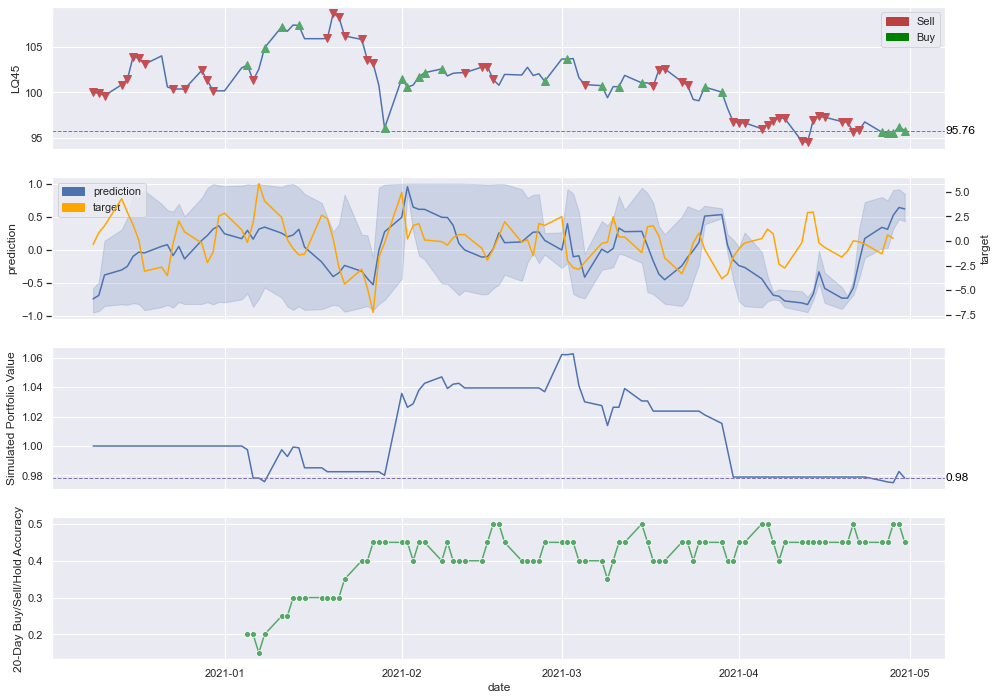

In [ ]:
res = sv_date_prediction.pipe(determine_buy_sell_acc, 0.15, -0.20)
res = sv_date_prediction.pipe(calc_rolling_acc)
res = res.merge(df[['LQ45','target']], how='left', left_index=True, right_index=True).copy()
res = res[:-1] # Remove last element because NaN

test_returns = tm.simulate_position(res,0.15,-0.15, closing_price_name='LQ45',buy_fee=0.0025,sell_fee=0.003)#dp.generate_returns(res)
sv_fig = plot_returns(test_returns, closing_price_name='LQ45', value_range=3, title='')
sv_fig.savefig('sv_fig.png', bbox_inches='tight')

In [ ]:
res['gauge_value'] = ((res['avg_pred']*10) + 10) /2

In [ ]:
res[['sv_pred_0','sv_pred_1','sv_pred_2','sv_pred_3','sv_pred_4','avg_pred','median_pred','gauge_value','pred_position','actual_position']].tail(20)

,sv_pred_0,sv_pred_1,sv_pred_2,sv_pred_3,sv_pred_4,avg_pred,median_pred,gauge_value,pred_position,actual_position
date,,,,,,,,,,
2021-04-05,-0.870098,-0.411014,-0.036362,0.296573,-0.674863,-0.339153,-0.375083,3.304237,SELL,SELL
2021-04-06,-0.778934,-0.529963,-0.396628,-0.087796,-0.867492,-0.532163,-0.531063,2.339187,SELL,BUY
2021-04-07,-0.751266,-0.672050,-0.636824,-0.370168,-0.951407,-0.676343,-0.674197,1.618285,SELL,BUY
2021-04-08,-0.746739,-0.597362,-0.762352,-0.486780,-0.976107,-0.713868,-0.730304,1.430660,SELL,BUY
2021-04-09,-0.867669,-0.608526,-0.843664,-0.612965,-0.986484,-0.783862,-0.813763,1.080691,SELL,SELL
2021-04-12,-0.923160,-0.626360,-0.861167,-0.674780,-0.990925,-0.815279,-0.838223,0.923607,SELL,SELL
2021-04-13,-0.944491,-0.710717,-0.829586,-0.694912,-0.990375,-0.834016,-0.831801,0.829920,SELL,HOLD
2021-04-14,-0.759089,-0.601000,-0.645587,-0.387192,-0.932996,-0.665173,-0.655380,1.674136,SELL,BUY
2021-04-15,-0.014833,-0.499441,-0.485674,0.264723,-0.842735,-0.315592,-0.400633,3.422040,SELL,BUY


In [ ]:
plot_gauge(res.avg_pred[-1])

In [ ]:
# explainer = shap.Explainer(diamond_hand_1)
# shap_values = explainer(X_current)

# Build HTML5 from prediction created

In [ ]:
from jinja2 import Environment, FileSystemLoader

env = Environment(loader=FileSystemLoader('.'))
template = env.get_template("lq45-forecast-report-template.html")

template_vars = {"title" : "LQ45 3-Day Forecast",
                 "gekko_forecast": 'gekko_gauge.png',
                 "gekko_plot":'sv_fig.png'}

html_out = template.render(template_vars)

#write html to file
text_file = open("lq45-forecast-report-{}.html".format(today.strftime("%Y-%m-%d")), "w")
text_file.write(html_out)
text_file.close()

# Run model `gekko`

In [ ]:
# Train period 2012-05-15 - 2020-12-31
gekko6var_1 = tf.keras.models.load_model('gekko/gru7_gs20_n60_6var_p2021-01-01_X31.hdf5', compile=False)
gekko6var_2 = tf.keras.models.load_model('gekko/gru7_gs20_n80_6var_p2021-01-01_X34.hdf5', compile=False)
gekko6var_3 = tf.keras.models.load_model('gekko/gru7_gs20_n80_6var_p2021-01-01_X4.hdf5', compile=False)
gekko6var_4 = tf.keras.models.load_model('gekko/gru7_gs20_n80_6var_p2021-01-01_X50.hdf5', compile=False)
gekko6var_5 = tf.keras.models.load_model('gekko/gru7_gs20_n60_6var_p2021-01-01_X47.hdf5', compile=False)

In [ ]:
from datetime import date

models = [gekko6var_1,gekko6var_2,gekko6var_3,gekko4var_4,gekko4var_5]
models_name = ['gekko6var_1','gekko6var_2','gekko6var_3','gekko4var_4','gekko4var_5']
pred_ensemble = []
oo_date_prediction = pd.DataFrame()

X, y = dp.generate_batch(df, 
                                         input_timesteps,
                                         output_timesteps,
                                         INPUT_VAR2,
                                         TARGET_VAR)

X_current, y_current = dp.generate_batch(df, 
                                         input_timesteps,
                                         output_timesteps,
                                         INPUT_VAR,
                                         TARGET_VAR)

# Genrate prediction from all model
for index,model in enumerate(models):
    pred,true,current_result = generate_prediction(model,
                                               X,
                                               y,
                                               df.index[(input_timesteps+output_timesteps-1):])
    val = target_inverse_transform(current_result['pred'].iloc[-day_count:].values).round(2) # get last X days
    pred_ensemble.append(val)
    oo_date_prediction['date'] = current_result['date']
    oo_date_prediction[f'nd_pred_{index}'] = current_result['pred']

# Convert to ndarray
pred_ensemble_npa = np.array(pred_ensemble)
today = date.today()

# Display and save result
oo_df = pd.DataFrame.from_dict({'model': models_name})

def highlight_sign(s): 
    res = ['color: red;' if x < -0.28 else 'color: green;' if x > 0.17 else 'color:black' for x in s] 
    return res

oo_df[today.strftime("%b %d, %Y")] = pred_ensemble_npa[:,-1]
for d in range(1, day_count):
    oo_df[df.index[-d].date().strftime("%b %d, %Y")] = pred_ensemble_npa[:,-1-d]
    
# Add avg, median
oo_df.loc[oo_df.index.max() + 1] = ['AVERAGE'] + np.flip(np.average(pred_ensemble_npa, axis=0),0).tolist()
oo_df.loc[oo_df.index.max() + 1] = ['MEDIAN'] + np.flip(np.median(pred_ensemble_npa, axis=0),0).tolist()

# Addd actual 3-day lQ45
# blender.loc[blender.index.max() + 1] = ['LQ45 3-DAY CHG'] + lq45_actual
lq45_actual = [np.nan] + np.flip(target_inverse_transform(current_result['true'].iloc[-day_count:].values).round(2)).tolist()[:-1]
oo_df.loc[oo_df.index.max() + 1] = ['LQ45 3-DAY CHG'] + lq45_actual

# Create dataframe to display portfolio value over time
oo_date_prediction.date = oo_date_prediction.date.shift(-1)
oo_date_prediction.date.iat[-1] = datetime.today().strftime('%Y-%m-%d')
oo_date_prediction.set_index(['date'],inplace=True)
oo_date_prediction['avg_pred'] = oo_date_prediction.mean(axis=1)
oo_date_prediction['median_pred'] = oo_date_prediction.median(axis=1)
oo_date_prediction['pred'] = oo_date_prediction['avg_pred']
oo_date_prediction['true'] = current_result['true'].values

# Styling and Display table
oo_df.set_index(['model'],inplace=True)
oo_df_styled = oo_df.style.format('{0:,.2f}%', na_rep="-")
oo_df_styled = oo_df_styled.set_caption("LQ45 Future 3-Day Forecast").apply(highlight_sign)
oo_df_styled = oo_df_styled.apply(lambda x: ['background: lightblue' if x.name in ['AVERAGE','MEDIAN','LQ45 3-DAY CHG'] else '' for i in x], axis=1)
oo_df_styled = oo_df_styled.apply(lambda x: ['background: gold' if x.name in ['LQ45 3-DAY CHG'] else '' for i in x], axis=1)
oo_df_styled

NameError: name 'gekko4var_4' is not defined

In [ ]:
res = oo_date_prediction.pipe(determine_buy_sell_acc, 0.15, -0.20)
res = oo_date_prediction.pipe(calc_rolling_acc)
res = res.merge(df[['LQ45','target']], how='left', left_index=True, right_index=True).copy()
res = res[:-1] # Remove last element because NaN

test_returns = tm.simulate_position(res,0.15,-0.2, closing_price_name='LQ45')#dp.generate_returns(res)
fig = plot_returns(test_returns, closing_price_name='LQ45', value_range=3, title='')

NameError: name 'oo_date_prediction' is not defined

# Run model `JIBOR`

In [ ]:
mypath = 'jibor_ma'

from os import listdir
from os.path import isfile, join

models = [tf.keras.models.load_model('jibor_ma/{}'.format(f), compile=False) for f in listdir(mypath) if isfile(join(mypath, f))]
models_name = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [ ]:
from datetime import date

# models = [oneoff1,oneoff2,gru8_mY70,gru8_mY136,gru8_mY196,gru8_mY164,gru8_mY34,gru8_mY276,gru8_mY212,gru8_mY24,gru8_newer_data_n80_4,gru8_newer_data_n60_3,gru8_newer_data_n45_2]
# models_name = ['oneoff1','oneoff2','gru8_mY70','gru8_mY136','gru8_mY196','gru8_mY164','gru8_mY34','gru8_mY276','gru8_mY212','gru8_mY24','gru8_newer_data_n80_4','gru8_newer_data_n60_3','gru8_newer_data_n45_2']
pred_ensemble = []
oo_date_prediction = pd.DataFrame()

df2 = df.copy()
indo_jibor = pd.read_csv('indonia_jibor.csv')
indo_jibor['Date'] = pd.to_datetime(indo_jibor['Date'], format='%d/%m/%Y')
indo_jibor = indo_jibor.set_index('Date').sort_index()
indo_jibor.loc[indo_jibor.indonia == 0, 'indonia'] = np.nan
indo_jibor.loc[indo_jibor.jibor_weekly == 0, 'jibor_weekly'] = np.nan

# indo_jibor.interpolate(inplace=True)
indo_jibor.fillna(method='bfill',inplace=True)
df2['jibor_ma'] = df2['jibor_weekly'].rolling(4).mean()

X_current, y_current = dp.generate_batch(df2, 
                                         input_timesteps,
                                         output_timesteps,
                                         ['momentum','IDX30_IHSG_grad','EIDO_SPY_grad','Volume_grad','jibor_ma'],
                                         TARGET_VAR)

# Genrate prediction from all model
for index,model in enumerate(models):
    pred,true,current_result = generate_prediction(model,
                                               X_current,
                                               y_current,
                                               df2.index[(input_timesteps+output_timesteps-1):])
    val = target_inverse_transform(current_result['pred'].iloc[-day_count:].values).round(2) # get last X days
    pred_ensemble.append(val)
    oo_date_prediction['date'] = current_result['date']
    oo_date_prediction[f'nd_pred_{index}'] = current_result['pred']

# Convert to ndarray
pred_ensemble_npa = np.array(pred_ensemble)
today = date.today()

# Display and save result
oo_df = pd.DataFrame.from_dict({'model': models_name})

def highlight_sign(s): 
    res = ['color: red;' if x < -0.28 else 'color: green;' if x > 0.17 else 'color:black' for x in s] 
    return res

oo_df[today.strftime("%b %d, %Y")] = pred_ensemble_npa[:,-1]
for d in range(1, day_count):
    oo_df[df.index[-d].date().strftime("%b %d, %Y")] = pred_ensemble_npa[:,-1-d]
    
# Add avg, median
oo_df.loc[oo_df.index.max() + 1] = ['AVERAGE'] + np.flip(np.average(pred_ensemble_npa, axis=0),0).tolist()
oo_df.loc[oo_df.index.max() + 1] = ['MEDIAN'] + np.flip(np.median(pred_ensemble_npa, axis=0),0).tolist()

# Addd actual 3-day lQ45
# blender.loc[blender.index.max() + 1] = ['LQ45 3-DAY CHG'] + lq45_actual
lq45_actual = [np.nan] + np.flip(target_inverse_transform(current_result['true'].iloc[-day_count:].values).round(2)).tolist()[:-1]
oo_df.loc[oo_df.index.max() + 1] = ['LQ45 3-DAY CHG'] + lq45_actual

# Create dataframe to display portfolio value over time
oo_date_prediction.date = oo_date_prediction.date.shift(-1)
oo_date_prediction.date.iat[-1] = date.today()
oo_date_prediction.set_index(['date'],inplace=True)
oo_date_prediction['avg_pred'] = oo_date_prediction.mean(axis=1)
oo_date_prediction['median_pred'] = oo_date_prediction.median(axis=1)
oo_date_prediction['pred'] = oo_date_prediction['avg_pred']
oo_date_prediction['true'] = current_result['true'].values

# Styling and Display table
oo_df.set_index(['model'],inplace=True)
oo_df_styled = oo_df.style.format('{0:,.2f}%', na_rep="-")
oo_df_styled = oo_df_styled.set_caption("LQ45 Future 3-Day Forecast").apply(highlight_sign)
oo_df_styled = oo_df_styled.apply(lambda x: ['background: lightblue' if x.name in ['AVERAGE','MEDIAN','LQ45 3-DAY CHG'] else '' for i in x], axis=1)
oo_df_styled = oo_df_styled.apply(lambda x: ['background: gold' if x.name in ['LQ45 3-DAY CHG'] else '' for i in x], axis=1)
oo_df_styled

In [ ]:
res = oo_date_prediction.pipe(calc_rolling_acc)
res = res.merge(df[['LQ45','target']], how='left', left_index=True, right_index=True).copy()
res = res[:-1] # Remove last element because NaN

test_returns = tm.simulate_position(res,0.15,-0.2, closing_price_name='LQ45')#dp.generate_returns(res)
fig = plot_returns(test_returns, closing_price_name='LQ45', value_range=3, title='')